the goal of this notebook is to create a XGBoost model using the gan synthetic dataset and see what the accuracy is without input regarding the orginal XGBoost model. Specifically, we can act as this is an entirely different dataset and just compare with the proper one hot encoding etc.

In [1]:
import sys
print(sys.executable)

/Users/mikayla/wallet-wisdom/env-xgboost/bin/python


In [2]:
# dependecies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier

In [3]:
synData = pd.read_csv('synData.csv')
synData.head()

,age,gender,raceEthnicity,education,region,householdType,householdSize,career,workArrangement,annualIncome,...,totalExpenses,totalSavingsInvestments,monthlyCashFlow,housingRatio,debtToIncome,savingsInvestmentsRate,carPaymentRatio,monthsSaved,financialHealth,ageCategory
0,31,Male,White,Bachelor's,South,Other,2,Retail,Office,20735.784791,...,5259.036875,1508.348715,279.594411,40.005986,20.203418,13.300729,-0.272846,2.038898,FinanciallyVulnerable,25-30
1,50,Female,Asian,High School,Midwest,DINKS,3,Healthcare,Office,88419.040967,...,4681.839130,2282.909017,92.799302,21.504035,36.983144,7.923803,0.224076,2.528271,FinanciallyDistressed,35-40
2,42,Male,White,Some College/Associate's,South,Roommates,2,Retail,Hybrid,29440.539611,...,7318.791074,55.342397,-1785.654438,109.752385,3.077163,8.880924,0.580108,1.524849,FinanciallyVulnerable,30-35
3,25,Male,White,Some College/Associate's,Midwest,SingleParent,1,Manufacturing,Hybrid,51488.705675,...,7646.014288,290.585052,-448.049187,15.944974,11.747448,14.177564,0.507766,3.610195,FinanciallyThriving,40-45
4,61,Female,Black/African American,Bachelor's,South,Other,4,Business,Office,33798.920912,...,6783.682666,2561.448598,-790.128703,14.964838,3.109067,14.420531,0.482580,2.131422,FinanciallyVulnerable,60-65


In [4]:
synData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 69 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         3500 non-null   int64  
 1   gender                      3500 non-null   object 
 2   raceEthnicity               3500 non-null   object 
 3   education                   3500 non-null   object 
 4   region                      3500 non-null   object 
 5   householdType               3500 non-null   object 
 6   householdSize               3500 non-null   int64  
 7   career                      3500 non-null   object 
 8   workArrangement             3500 non-null   object 
 9   annualIncome                3500 non-null   float64
 10  sideHustleIncome            3500 non-null   float64
 11  monthlyIncome               3500 non-null   float64
 12  housingStatus               3500 non-null   object 
 13  housingCost                 3500 

In [5]:
synData.describe()

,age,householdSize,annualIncome,sideHustleIncome,monthlyIncome,housingCost,propertyTax,hoaFees,homeInsurance,utilities,...,investmentContributions,contributions529,totalExpenses,totalSavingsInvestments,monthlyCashFlow,housingRatio,debtToIncome,savingsInvestmentsRate,carPaymentRatio,monthsSaved
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,...,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,45.315429,2.232000,35983.476798,545.523905,5396.302800,2677.828427,58.464640,8.361807,78.256084,200.168421,...,43.213783,0.564752,5669.218905,916.131762,-1321.064062,52.924450,15.396461,11.363017,6.147293,2.755900
std,14.060070,1.062443,23980.971833,2713.508204,3507.714084,1197.673714,88.293120,46.681343,60.411478,50.567919,...,188.660356,25.191283,2311.053458,915.268566,2425.096698,24.185791,13.668691,8.455661,9.955177,1.570419
min,23.000000,1.000000,-12310.922637,-607.290157,-241.375979,451.075151,-81.651329,-6.188429,3.451740,100.749994,...,-11.583923,-32.727609,382.335773,-67.797957,-9902.160256,6.899938,-2.318697,-1.729045,-0.546799,-0.347599
25%,31.000000,2.000000,18836.613360,-26.596676,2870.139468,1835.367629,-6.288354,-1.360691,23.985229,163.488373,...,4.036233,-3.061134,4070.914584,137.922244,-2707.711463,34.950868,3.013015,5.182654,0.259533,1.691323
50%,45.000000,2.000000,29436.582404,60.178044,4285.136770,2440.614842,2.443285,0.638513,69.435092,193.530942,...,7.924727,-1.874187,5283.120287,614.371099,-1329.698656,50.114933,11.897547,10.432163,0.473030,2.290883
75%,55.000000,3.000000,46472.142626,141.630136,6940.902674,3255.022238,111.642884,2.605855,129.396694,229.029815,...,11.321737,-0.457470,6748.556528,1384.840545,-158.693225,66.903318,24.474650,16.348196,13.719854,3.952288
max,79.000000,6.000000,178679.297736,36790.846920,19778.133397,8702.621247,751.263613,489.093285,224.186024,402.368917,...,1635.167752,532.781604,18530.753239,5175.446679,8328.780138,189.694183,58.966598,40.495907,32.947272,7.369317


In [6]:
synData.shape

(3500, 69)

In [7]:
synData.select_dtypes(include='object')

,gender,raceEthnicity,education,region,householdType,career,workArrangement,housingStatus,financialHealth,ageCategory
0,Male,White,Bachelor's,South,Other,Retail,Office,Rent,FinanciallyVulnerable,25-30
1,Female,Asian,High School,Midwest,DINKS,Healthcare,Office,Rent,FinanciallyDistressed,35-40
2,Male,White,Some College/Associate's,South,Roommates,Retail,Hybrid,Own,FinanciallyVulnerable,30-35
3,Male,White,Some College/Associate's,Midwest,SingleParent,Manufacturing,Hybrid,Own,FinanciallyThriving,40-45
4,Female,Black/African American,Bachelor's,South,Other,Business,Office,Rent,FinanciallyVulnerable,60-65
...,...,...,...,...,...,...,...,...,...,...
3495,Male,White,High School,Midwest,DINKS,Construction,Office,Rent,FinanciallyDistressed,30-35
3496,Female,Hispanic/Latino,Bachelor's,West,SmallFamily,Transportation,Hybrid,Own,FinanciallyDistressed,40-45
3497,Female,Hispanic/Latino,Master's,West,Roommates,Healthcare,PartTime,Own,FinanciallyThriving,55-60
3498,Male,White,Bachelor's,West,Single,Retail,Office,Own,FinanciallyDistressed,30-35


In [8]:
# one hot encoding
ohe_gender = pd.get_dummies(synData.gender)
ohe_race = pd.get_dummies(synData.raceEthnicity)
ohe_education = pd.get_dummies(synData.education)
ohe_region = pd.get_dummies(synData.region)
ohe_householdT = pd.get_dummies(synData.householdType)
ohe_career = pd.get_dummies(synData.career)
ohe_workA = pd.get_dummies(synData.workArrangement)
ohe_housingS = pd.get_dummies(synData.housingStatus)

In [9]:
synData = pd.concat([synData, ohe_education, ohe_career, ohe_gender, ohe_workA, ohe_region,
                     ohe_race, ohe_housingS, ohe_householdT], axis=1)
synData.head()

,age,gender,raceEthnicity,education,region,householdType,householdSize,career,workArrangement,annualIncome,...,Other/Multiracial,White,Own,Rent,DINKS,Other,Roommates,Single,SingleParent,SmallFamily
0,31,Male,White,Bachelor's,South,Other,2,Retail,Office,20735.784791,...,False,True,False,True,False,True,False,False,False,False
1,50,Female,Asian,High School,Midwest,DINKS,3,Healthcare,Office,88419.040967,...,False,False,False,True,True,False,False,False,False,False
2,42,Male,White,Some College/Associate's,South,Roommates,2,Retail,Hybrid,29440.539611,...,False,True,True,False,False,False,True,False,False,False
3,25,Male,White,Some College/Associate's,Midwest,SingleParent,1,Manufacturing,Hybrid,51488.705675,...,False,True,True,False,False,False,False,False,True,False
4,61,Female,Black/African American,Bachelor's,South,Other,4,Business,Office,33798.920912,...,False,False,False,True,False,True,False,False,False,False


In [10]:
le = LabelEncoder()
synY = le.fit_transform(synData['financialHealth'])

In [11]:
# test train split
synX = synData.drop(['gender', 'raceEthnicity', 'education', 'region', 'householdType',
              'career', 'workArrangement', 'housingStatus', 'financialHealth',
              'ageCategory'], axis=1)
featureNames = synX.columns
synXtrain, synXtest, synYtrain, synYtest = train_test_split(synX, synY, test_size=0.2, random_state=42)

In [12]:
synYtrain = synYtrain.flatten()
synYtrain.shape

(2800,)

In [13]:
synXtrain = synXtrain.astype('float32').values
synXtest = synXtest.astype('float32').values
synYtrain = synYtrain.astype('int')

In [14]:
# model
synModel = XGBClassifier(random_state=42, n_estimators=100, max_depth=4)
synModel.fit(synXtrain, synYtrain)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[typing.Callable, str]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [15]:
# evaluate
synYpred = synModel.predict(synXtest)
print(classification_report(synYtest, synYpred))

              precision    recall  f1-score   support

           0       0.47      0.66      0.55       317
           1       0.00      0.00      0.00        82
           2       0.67      0.04      0.08        45
           3       0.38      0.37      0.38       256

    accuracy                           0.44       700
   macro avg       0.38      0.27      0.25       700
weighted avg       0.40      0.44      0.39       700



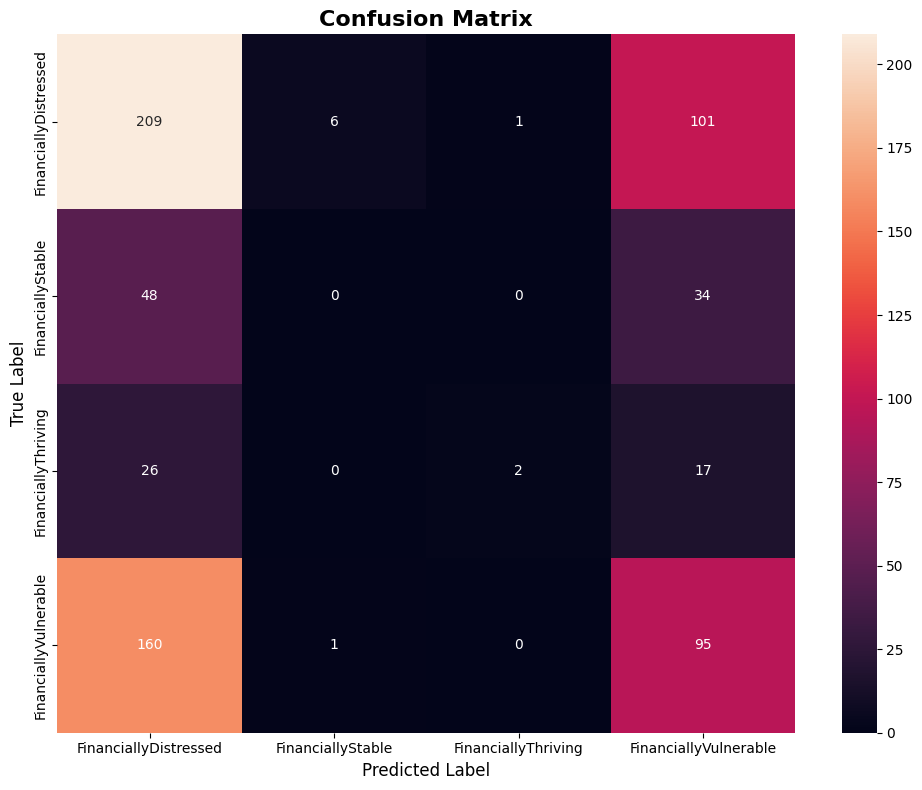

In [16]:
# confusion matrix
cm = confusion_matrix(synYtest, synYpred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize = 16, fontweight = 'bold')
plt.xlabel('Predicted Label', fontsize = 12)
plt.ylabel('True Label', fontsize = 12)
plt.tight_layout()

In [18]:
# Get feature importances as a dictionary
importances = synModel.get_booster().get_score(importance_type='weight')

# Match them to the real column names
feature_map = {f"f{i}": col for i, col in enumerate(featureNames)}

# Translate importances
named_importances = {feature_map.get(k, k): v for k, v in importances.items()}

# Sort and view
pd.Series(named_importances).sort_values(ascending=False)

publicTransit        103.0
gas                  100.0
debtToIncome          94.0
gym                   93.0
retirement401k        93.0
                     ...  
Legal                  1.0
Other/Multiracial      1.0
FoodService            1.0
Other                  1.0
Roommates              1.0
Length: 99, dtype: float64